The notebook is used to visualize the performance of PCE

In [1]:
# import packages
import pandas as pd
import numpy as np
from veneer.pest_runtime import *
from veneer.manage import start,kill_all_now
import os

from funcs.read_data import variables_prep, file_settings
from funcs.modeling_funcs import vs_settings, \
        modeling_settings, paralell_vs, obtain_initials, change_param_values

In [2]:
# define the function for adaptive pce
vs_list = []

def run_source_annual(vars, vs_list=vs_list):
    """
    Script used to run_source and return the output file.
    The function is called by AdaptiveLejaPCE.
    """
    from funcs.modeling_funcs import modeling_settings, generate_observation_ensemble
    print('Read Parameters')
    parameters = pd.read_csv('../data/Parameters-PCE.csv', index_col='Index')

    # import observation if the output.txt requires the use of obs.
    date_range = pd.to_datetime(['2017/07/01', '2018/06/30'])
    observed_din = pd.read_csv(f'{file_settings()[1]}126001A.csv', index_col='Date')
    observed_din.index = pd.to_datetime(observed_din.index)
    observed_din = observed_din.loc[date_range[0]:date_range[1], :].filter(items=[observed_din.columns[0]]).apply(lambda x: 1000 * x)
    
    # loop over the vars and try to use parallel     
    parameter_df = pd.DataFrame(index=np.arange(vars.shape[1]), columns=parameters.Name_short)
    for i in range(vars.shape[1]):
        parameter_df.iloc[i] = vars[:, i]

    # set the time period of the results
    retrieve_time = [pd.Timestamp('2017-07-01'), pd.Timestamp('2018-06-30')]

    # define the modeling period and the recording variables
    _, _, criteria, start_date, end_date = modeling_settings()
    din = generate_observation_ensemble(vs_list, 
        criteria, start_date, end_date, parameter_df, retrieve_time)
    breakpoint()
    if din.mean(axis=0)[0] == 0:
        cv = np.array([1e-5]) # Set the cv at 1e-5 to satisfy the requirements of the adaptive_polynomial_chaos
    else:
        breakpoint()
        cv = np.array(din.std(axis = 0).values / din.mean(axis = 0).values)

    if cv.shape[0] > 1:
        breakpoint()
    cv = cv.reshape(cv.shape[0], 1)
    print(f'Finish {cv.shape[0]} run')

    return cv
# END run_source()

## import samples and results for the pce-cv

In [20]:
import pickle
pce_load = pickle.load(open(f'{file_settings()[0]}\pce-lsq.pkl', "rb"))

In [21]:
# import the validation set
vali_samples = pd.read_csv(f'{file_settings()[1]}samples.csv', index_col='real_name')
vali_values = pd.read_csv(f'{file_settings()[1]}DIN_126001A.csv', index_col = 'Unnamed: 0')

In [5]:
vali_cv = (vali_values.std(axis=0) / vali_values.mean(axis=0)).values
pce_vals = pce_load(vali_samples.values.T)

## import samples and results for pce-sse

In [3]:
import pickle
year = 2017
pce_load = pickle.load(open(f'{file_settings()[0]}\pce-{year}-level4.pkl', "rb"))

In [4]:
# Define objective functions
# Use annual or monthly loads
def timeseries_sum(df, temp_scale = 'annual'):
    """v
    Obtain the sum of timeseries of different temporal scale.
    temp_scale: str, default is 'Y', monthly using 'M'
    """
    assert temp_scale in ['monthly', 'annual'], 'The temporal scale given is not supported.'
    if temp_scale == 'monthly':
        sum_126001A = df.resample('M').sum()
    else:
        month_126001A = df.resample('M').sum()
        sum_126001A = pd.DataFrame(index = np.arange(df.index[0].year, df.index[-1].year), 
            columns=df.columns)
        for i in range(sum_126001A.shape[0]):
            sum_126001A.iloc[i, :] = month_126001A.iloc[i*12: (i+1)*12, :].sum()

    return sum_126001A
# End timeseries_sum()

In [5]:
# import observation if the output.txt requires the use of obs.
date_range = pd.to_datetime(['2009/07/01', '2018/06/30'])
observed_din = pd.read_csv(f'{file_settings()[1]}126001A.csv', index_col='Date')
observed_din.index = pd.to_datetime(observed_din.index)
observed_din = observed_din.loc[date_range[0]:date_range[1], :].filter(items=[observed_din.columns[0]]).apply(lambda x: 1000 * x)

In [6]:
# import the validation set
vali_samples = pd.read_csv(f'{file_settings()[1]}samples.csv', index_col='real_name')
vali_values = pd.read_csv(f'{file_settings()[1]}DIN_126001A.csv', index_col = 'Unnamed: 0')
vali_values.index = pd.to_datetime(vali_values.index)

In [7]:
# calculate the summed squared residuals of annual loads
vali_annual = timeseries_sum(vali_values, temp_scale = 'annual')
obs_din = timeseries_sum(observed_din, temp_scale = 'annual')
din_126001A = pd.DataFrame(vali_annual, dtype='float')
if year != 'sse':
    lsq = din_126001A.loc[year, :].values
else:
    resid = (obs_din.values - vali_annual.values)
    lsq = np.sum(resid ** 2, axis=0)
    lsq = lsq.reshape(lsq.shape[0], 1)

model_vals = lsq

In [8]:
# calculate the outputs of pce
pce_vals = pce_load(vali_samples.values.T)

## Scatter plot of validation samples

In [9]:
import matplotlib.pyplot as plt
from matplotlib import rc
import latex
rc("text", usetex=False)
import seaborn as sns
from sklearn import metrics

In [10]:
# calculate the error 
r2 = metrics.r2_score(model_vals.flatten()[0:1000], pce_vals.flatten()[0:1000])
r2

0.9999984345027167

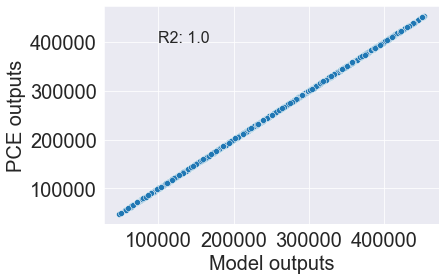

In [13]:
sns.set_style('darkgrid')
ax = sns.scatterplot(x = model_vals.flatten()[0:1000], y = pce_vals.flatten()[0:1000])
ax.set_xlabel('Model outputs')
ax.set_ylabel('PCE outputs')
ax.text(x=1e5, y=4e5, s=f'R2: {np.round(r2, 2)}');
# Add a 1-1 line
# x_line = np.linspace(0, 2.5e6, 10000)
# y_line = x_line
# sns.lineplot(x = x_line, y = y_line, color='k', ax=ax, linestyle='--', alpha=0.5)
plt.savefig(f'{file_settings()[0]}figs/PCE_{year}.png', format='png', dpi=300)